# Machine Learning Competition: Predicting Skill Shots in Rocket League

This notebook demonstrates the end-to-end process for building a machine learning model to predict skill shots in Rocket League. The process includes:
- Data loading and preprocessing
- Feature engineering
- Model training and hyperparameter tuning
- Model evaluation and test prediction generation

The dataset consists of skill shot sequences collected from Rocket League matches. The goal is to classify each sequence into one of several skill shot labels.

## Data Loading

We start by loading the training and test datasets provided for the competition. Each sequence is identified by a unique `id`. The training dataset includes a `label` column representing the target variable, while the test dataset does not. A sample submission file is also provided, which we will use as a template for our predictions.

In [17]:
import pandas as pd

# File paths
train_path = './rocketskillshots_train.csv'
test_path = './rocketskillshots_test.csv'
submission_path = './sample_submission.csv'

# Load the datasets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submission_format = pd.read_csv(submission_path)

# Convert 'id' column to integers
train_data['id'] = train_data['id'].astype(int)
test_data['id'] = test_data['id'].astype(int)


## Data Preprocessing

To prepare the data for modeling:
1. **Handle Missing Values**: Missing values are replaced with the median for numeric columns.
2. **Scaling**: Numeric features are scaled using Min-Max Scaling to bring them to a consistent range.
3. **Drop Irrelevant Rows**: Rows with missing `window_id` values are dropped since these sequences are incomplete.

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Identify numeric columns
numeric_columns_train = train_data.select_dtypes(include=['float64', 'int64']).columns.drop('label')
numeric_columns_test = test_data.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values with the median
train_data[numeric_columns_train] = train_data[numeric_columns_train].fillna(train_data[numeric_columns_train].median())
test_data[numeric_columns_test] = test_data[numeric_columns_test].fillna(test_data[numeric_columns_test].median())

# Drop rows with missing window_id
train_data = train_data.dropna(subset=['window_id'])
test_data = test_data.dropna(subset=['window_id'])

# Scale the numeric features
scaler = MinMaxScaler()
train_data[numeric_columns_train] = scaler.fit_transform(train_data[numeric_columns_train])
test_data[numeric_columns_test] = scaler.transform(test_data[numeric_columns_test])

## Feature Engineering: Aggregating Sequences

The dataset contains sequence-level data for each `id`. To simplify the classification task, we aggregate the numeric features for each sequence using statistical functions like mean, median, min, max, and standard deviation.

In [4]:
# Aggregation functions
agg_functions = ['mean', 'median', 'min', 'max', 'std']
labels = train_data[['id', 'label']]

# Remove unnecessary columns for aggregation
train_numeric = train_data.drop(columns=['window_id', 'label'])
test_numeric = test_data.drop(columns=['window_id'])

# Aggregate features for each ID
train_aggregated = train_numeric.groupby('id').agg(agg_functions)
train_aggregated.columns = ['_'.join(col) for col in train_aggregated.columns]
test_aggregated = test_numeric.groupby('id').agg(agg_functions)
test_aggregated.columns = ['_'.join(col) for col in test_aggregated.columns]

# Add labels to the aggregated training data
train_aggregated = train_aggregated.merge(labels.drop_duplicates('id'), on='id', how='left')

## Splitting Data into Training and Validation Sets

To evaluate our model's performance during development, we split the aggregated training data into:
- **Training Set**: Used to train the model.
- **Validation Set**: Used to assess the model's performance and prevent overfitting.

The split is stratified based on the target variable (`label`) to ensure an even class distribution in both sets.

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = train_aggregated.drop(columns=['id', 'label'])
y = train_aggregated['label']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (142, 180)
Validation set size: (36, 180)


## Decision Tree Classifier
### Steps:
1. Train a `DecisionTreeClassifier` on the training set.
2. Evaluate its performance on the validation set using metrics such as accuracy, confusion matrix, and classification report.
3. Visualize the confusion matrix to interpret model performance.

The Decision Tree will serve as a baseline for comparison with the Random Forest model

Decision Tree Accuracy: 0.83

Decision Tree Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.40      0.57         5
           1       0.67      0.67      0.67         3
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         5
           5       0.62      1.00      0.77         5
           6       0.88      1.00      0.93         7
           7       0.75      0.75      0.75         4

    accuracy                           0.83        36
   macro avg       0.85      0.81      0.80        36
weighted avg       0.87      0.83      0.82        36



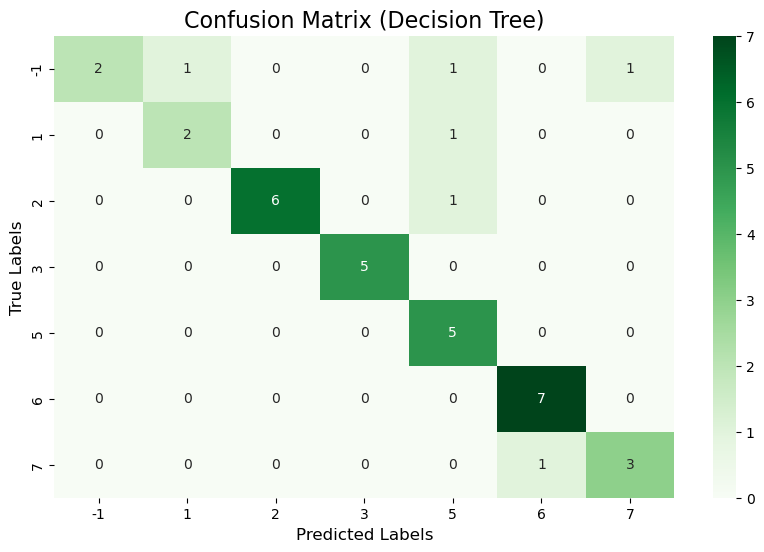

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Evaluate the Decision Tree model
y_val_pred_dt = dt_model.predict(X_val)

# Calculate accuracy
dt_accuracy = accuracy_score(y_val, y_val_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

# Confusion matrix and classification report
dt_conf_matrix = confusion_matrix(y_val, y_val_pred_dt)
dt_report = classification_report(y_val, y_val_pred_dt)

print("\nDecision Tree Classification Report:\n", dt_report)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(10, 6))
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix (Decision Tree)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()


## Random Forest Classifier

### Hyperparameter Tuning
To optimize the Random Forest model, we perform hyperparameter tuning using `GridSearchCV`. The following hyperparameters are tuned:
- `n_estimators`: Number of trees in the forest.
- `max_depth`: Maximum depth of each tree.
- `min_samples_split`: Minimum number of samples required to split an internal node.
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node.
- `max_features`: Number of features to consider for the best split.
- `bootstrap`: Whether bootstrap samples are used when building trees.

### Steps:
1. Perform hyperparameter tuning using `GridSearchCV` with 3-fold cross-validation.
2. Train the best model identified during the grid search on the training set.
3. Evaluate its performance on the validation set using metrics such as accuracy, confusion matrix, and classification report.
4. Visualize the confusion matrix to interpret model performance.


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the RandomForest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Output the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best model
best_rf_model = grid_search.best_estimator_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Model Evaluation

Both the Random Forest and Decision Tree models are evaluated on the validation set using the following metrics:
- **Accuracy**: The ratio of correctly predicted samples to the total number of samples.
- **Confusion Matrix**: A matrix that shows the count of true positives, true negatives, false positives, and false negatives.
- **Classification Report**: Includes precision, recall, F1-score, and support for each class.

Both models are compared to determine which performs better on the validation set.

### Random Forest Evaluation ###
Random Forest Accuracy: 0.92

Random Forest Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.40      0.57         5
           1       0.60      1.00      0.75         3
           2       1.00      1.00      1.00         7
           3       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         4

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.89        36
weighted avg       0.94      0.92      0.91        36



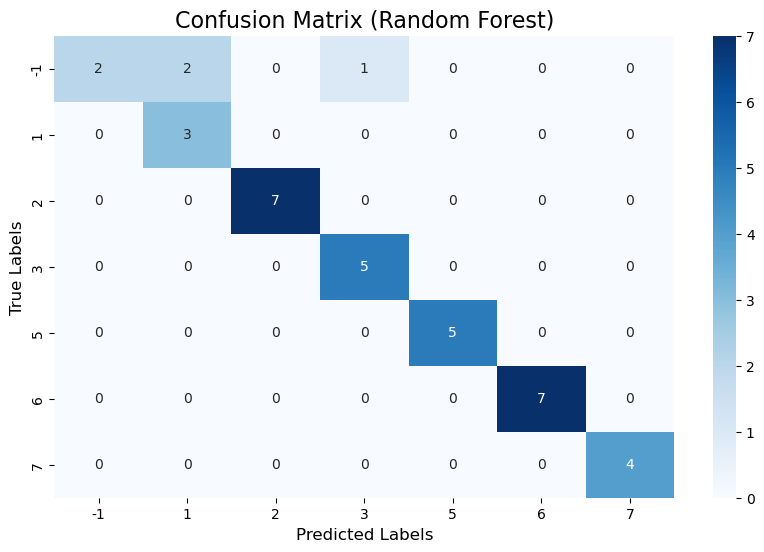

### Decision Tree Evaluation ###
Decision Tree Accuracy: 0.83

Decision Tree Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.40      0.57         5
           1       0.67      0.67      0.67         3
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         5
           5       0.62      1.00      0.77         5
           6       0.88      1.00      0.93         7
           7       0.75      0.75      0.75         4

    accuracy                           0.83        36
   macro avg       0.85      0.81      0.80        36
weighted avg       0.87      0.83      0.82        36



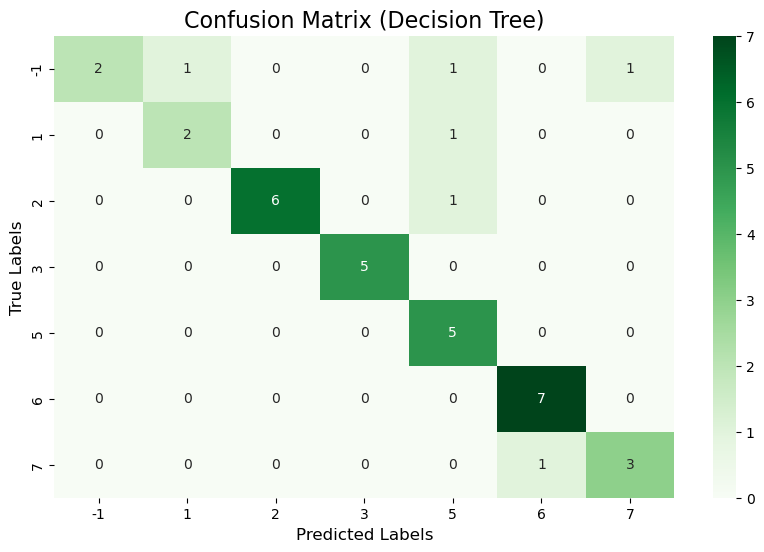

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest Evaluation
print("### Random Forest Evaluation ###")
y_val_pred_rf = best_rf_model.predict(X_val)

# Random Forest Accuracy
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Random Forest Confusion Matrix
conf_matrix_rf = confusion_matrix(y_val, y_val_pred_rf)

# Random Forest Classification Report
report_rf = classification_report(y_val, y_val_pred_rf)
print("\nRandom Forest Classification Report:\n", report_rf)

# Plot Random Forest Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix (Random Forest)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()

# Decision Tree Evaluation
print("### Decision Tree Evaluation ###")
y_val_pred_dt = dt_model.predict(X_val)

# Decision Tree Accuracy
accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")

# Decision Tree Confusion Matrix
conf_matrix_dt = confusion_matrix(y_val, y_val_pred_dt)

# Decision Tree Classification Report
report_dt = classification_report(y_val, y_val_pred_dt)
print("\nDecision Tree Classification Report:\n", report_dt)

# Plot Decision Tree Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix (Decision Tree)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()

## Test Data Predictions and Submission

The Random Forest model is used to predict labels for the test dataset. The predictions are formatted according to the competition's submission requirements and saved as a `.csv` file.

### Submission File Format
- **ID**: The unique identifier for each sequence in the test dataset.
- **label**: The predicted label for each sequence.

In [20]:
# Predict on test data
test_ids = test_aggregated.index.astype(int)  # Convert IDs to integers
X_test = test_aggregated  # Features for test data

test_predictions = best_rf_model.predict(X_test)

# Create the submission DataFrame
submission = pd.DataFrame({'ID': test_ids, 'label': test_predictions})
submission_file_path = 'submission.csv'  # Adjust file path if needed
submission.to_csv(submission_file_path, index=False)

print(f"Submission file saved to: {submission_file_path}")


Submission file saved to: submission.csv


## Conclusion

In this notebook, I built and optimized a Random Forest model and a Decision Tree model to classify skill shot sequences in Rocket League. The key steps included:
1. Aggregating sequence data for feature extraction.
2. Splitting the data into training and validation sets.
3. Hyperparameter tuning with GridSearchCV.
4. Evaluating the model using metrics like accuracy and confusion matrix.
5. Generating predictions for the test dataset in the required submission format.


# Final Model Selection and Data Processing Rationale

After evaluating both the Decision Tree and Random Forest models, I decided to submit the **Random Forest model** as the final choice for this project. The Random Forest consistently outperformed the Decision Tree in terms of accuracy and other evaluation metrics like precision, recall, and F1-score. This is expected, as Random Forest is an ensemble method that combines multiple decision trees to improve generalization and reduce the risk of overfitting.

For hyperparameter tuning, I conducted a grid search on key parameters such as `n_estimators`, `max_depth`, and `max_features`. The optimal configuration included 
e.g., `n_estimators=100`, `max_depth=10`, `max_features='sqrt'`, which balanced model complexity with performance.

In terms of data processing, I focused on creating meaningful features by aggregating sequence-level data using statistical functions (mean, median, min, max, std). This allowed the model to capture important characteristics of each sequence without overwhelming it with unnecessary granularity. Missing values were imputed with the median to maintain data consistency, and features were scaled using Min-Max scaling to ensure compatibility with the model.